# Clase 7 - Modos Empíricos con SVD

**2do Cuatrimestre 2020**

**DF - FCEyN - UBA**

En este Notebook vamos a trabajar con datos experimentales correspondientes a una película del aparato fonador de un ave. En este sistema una membrana oscila debedio a la interacción con un flujo de aire (mismo fenómeno que sucede, por ejemplo, en nuestras cuerdas vocales). 

Aquí la película en cuestión:

In [ ]:
from IPython.display import Image
Image(url='http://materias.df.uba.ar/sdeiaaamdda2020c2/files/2012/07/membranagif.gif')

### 1. Carpeta de Trabajo y Lectura de Archivos

Primero, vamos a montarnos sobre el directorio de google Drive. Esto nos permitira leer y guardar archivos en nuestro Drive. Generamos la dirección `root_dir` (un string) que apunta a la carpeta de trabajo. Noten que al ejecutar el comando `mount`, google nos pedirá una contraseña la cual obtendremos mediante el link que aparece.

**Nota:** Recuerden que primero deben crear en su drive la carpeta.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

# Aca deben apuntar a la carpeta de su drive donde guardaron los datos
#root_dir = "/content/gdrive/My Drive/Materia_ModeladoDeDatos/Clases/Clase_7_ModosEmpiricos/GIF/"
root_dir = "/content/gdrive/My Drive/curso_gabo/GIF/"

Mounted at /content/gdrive


Para obetner la lista de los archivos que hay en la carpeta, vamos a utilizar la librería glob. 

In [ ]:
import glob

lista=[]
lista=glob.glob(root_dir+'*.jpg')
lista.sort()

print(len(lista))
print(lista[0])

95
/content/gdrive/My Drive/curso_gabo/GIF/Copy of 00094small.jpg


Como verán, los archivos constan de 95 frames (imagenes) de la película. Para leer estas imágenes vamos a utilizar la función `load_img` de la librería `Keras`.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

x=[]
for file in lista:    
    img = image.load_img(file, color_mode="grayscale")# target_size=80,120= 120*167
    x.append(image.img_to_array(img))

x = np.array(x)

print(x.shape)

(95, 167, 120, 1)


### 2. Preprocesamiento

Primero vamos a adecuar las imágenes con las que vamos a trabajar, es decir vamos a llevarlas a una forma adecauda para poder aplicarles el algortimo de SVD.

In [ ]:
# Construyo tensor X de mxhxb con n = # de frames, h=altura, b=base.
X = x[:,:,:,0]

# Normalizamos: llevamos de [0,255] a [0,1]
X = X.astype('float32')/255

# Restamos la imagen Media
X_medio = np.mean(X)
X = X-X_medio

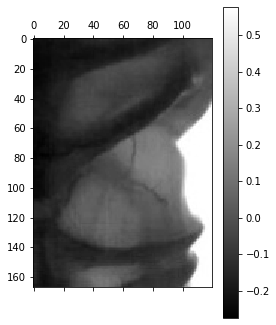

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# Graficamos un frame como ejemplo
numero = 55
plt.matshow(X[numero],cmap='gray')
plt.colorbar()
plt.show()

Por ultimo, vamos "aplastar" el tensor que contiene las 95 imágenes. Es decir que vamos a llevarlo a una forma $(n,m)$ siendo $n = altura \times base$ y siendo $ m = \# \  frames$ .

In [ ]:
# Tomamos las dimensiones de X
dims = np.shape(X)

# Construyo matriz Y de nxm con n = altura x base, m = num de frames
Y = np.transpose(np.reshape(X,(dims[0],dims[1]*dims[2])))

print('Shape de la matrix original',np.shape(X))
print('Shape de la matrix aplanada',np.shape(Y))
#20,040 = 167*120

Shape de la matrix original (95, 167, 120)
Shape de la matrix aplanada (20040, 95)


### 3. Aplicamos SVD

Usaremos la función de la libreria de algebra lineal de numpy `np.linalg.svd` para realizar la descomposición.

Con esto calculamos los modos empiricos. 

In [ ]:
#SVD para los primeros N frames
N = 95

# # SVD Completo
# Uhat, Shat, Vhat = np.linalg.svd(Y[:,:N],full_matrices=True)
# Shat es la matriz sigma
# SVD Económico
Uhat, Shat, Vhat = np.linalg.svd(Y[:,:N], full_matrices=False)


print('Shape de U:',Uhat.shape)
print('Shape de Shat:',Shat.shape)
print('Shape de Vhat:',Vhat.shape)

Shape de U: (20040, 95)
Shape de Shat: (95,)
Shape de Vhat: (95, 95)


**Ejercicio:** 
Cambie del SVD completo al SVD económico y vea como cambia la forma de las matrices. ¿Qué es lo que está cambiando entre ambos manera de computar la descomposición?

**Lo que cambia entre SVD completo y economico es el shape de la matriz U. En el completo U es de 20,040x20,040 y en el SVD economico U es de 20,040x95**

Vamos a graficar el valor de cada uno de los valores singulares y la suma cumulativa de los mismos:

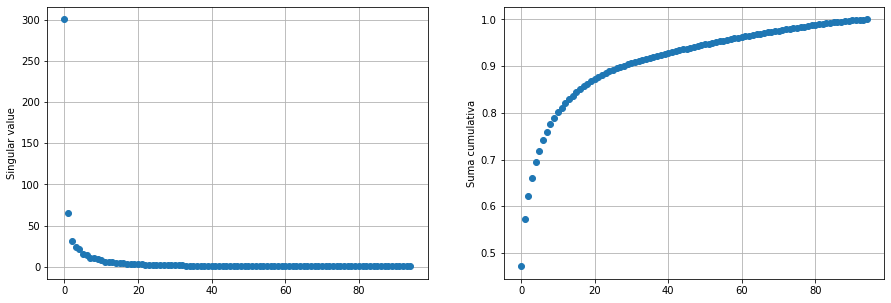

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(Shat,'o')
plt.ylabel('Singular value')
plt.grid()
plt.yscale('linear')
plt.subplot(1,2,2)
plt.plot(np.cumsum(Shat)/np.sum(Shat),'o')
plt.ylabel('Suma cumulativa')
plt.grid()


**el mean squeare error entre la peli posta y la reconstruida con r modos truncados tiene que ver con la suma cumulativa.** 

Noten que en la matriz Uhat guardamos la información de los modos espaciales como columnas, mientras que en la matriz Vhat guardamos la evolucion temporal de cada uno de estos modos como filas.

Veamos como lucen los primeros 6 modos espaciales. 

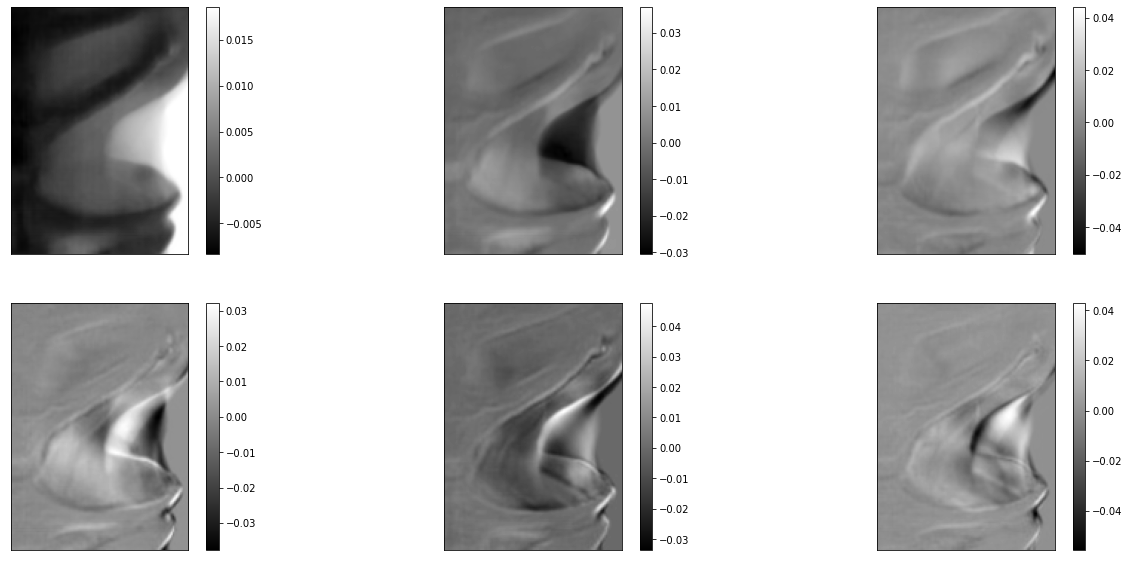

In [ ]:
plt.figure(figsize=(22,10))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(np.reshape(Uhat[:,i],(dims[1],dims[2])),cmap='gray',vmin=np.min(Uhat[:,i]),vmax=np.max(Uhat[:,i]))
  plt.xticks([])
  plt.yticks([])
  plt.colorbar()

**El primer modo (primera fila, primera columna) no esta involucrado en la oscilacion, es como la luminosidad. En la oscilacion esta el modo 2 (fila 1 segunda columna) que dice si hay o no membrana en la region (es el movimiento tipo piston en x, movimiento lateral) y el modo 3 (fila 1 tercera columna) es el modo tipo ondita. Necesito combinar los dos modos para que cuando los combine quede un patron divergente cuando los labios se acercan y un patron convergente cuando los labios se alejan. Si prendo el modo 2 lo q va a cambiar en la imagen es la zona negra.** 

Hay dos modos. Uno que es simetrico en x (fila 1, columna 2). Cuya activacion va a ser que algo simetrica se prendiera o apagara. Y otro modo que rompe la simetria en el eje y, es mas clarito por arriba y mas oscuro por abajo (fila 1, columna 3). Este es el que nos va a servir para describir las cosas como onditas. Una cosa simetrica no sirve, pero algo que rompe la simetria respecto de y si nos sirve para tener algo de tipo ondita. El primer modo es con el que represento el x medio (puede ser el modo 0) y el otro modo es el que necesito para representar la ondita que va de abajo hacia arriba.

#### 3. Evolucion Temporal de los modos

Exploremos como evolucionan temporalmente los primeros 4 modos empíricos.

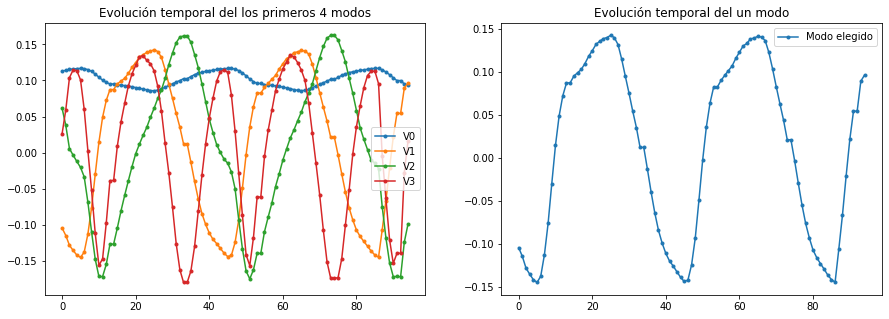

In [ ]:
#PRIMEROS MODOS TEMPORALES

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(Vhat[0],'.-',label='V0')
plt.plot(Vhat[1],'.-',label='V1')
plt.plot(Vhat[2],'.-',label='V2')
plt.plot(Vhat[3],'.-',label='V3')
plt.title('Evolución temporal del los primeros 4 modos')
plt.legend()
plt.subplot(1,2,2)

modo = 1
plt.plot(Vhat[modo],'.-',label='Modo elegido')
plt.title('Evolución temporal del un modo')
plt.legend()


plt.show()

Para distintos modos espaciales tengo distintas evoluciones temporales.  Estas son las amplitudes de los modos. Esto son las soluciones de las ecuaciones diferenciales ordinarias para las amplitudes temporales. Podemos no tener las ecuaciones diferenciales ordinarias para la amplitud temporal, pero tengo la solucion a esas ecuaciones mediante el SVD de la pelicula.  

Si graficamos la evolución temporal de los primeros 3 modos:

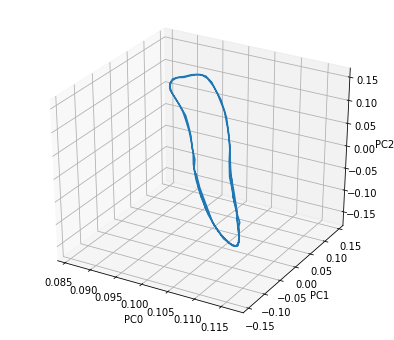

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax = fig.gca(projection='3d')
ax.plot(Vhat[0],Vhat[1],Vhat[2])
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.show()

**el grafico anterior es un ciclo limite pero no se ve perfecto porque la membrana es algo biologico, no es perfecta la oscilacion.**
**Cuando hago SVD estoy reduciendo la dimensionalidad, pero SVD NO ES UN EMBEDDING. Embedding es con seniales temporales.**

El grafico anterior es cual es la proyeccion en los primeros 3 modos. Es calcular un espacio de fases. La proyeccion en estos modos es un circulo, es decir, es un ciclo limite. Esto es proyectar en un espacio de fases empirico una dinamica. La pelicula era re dificil, y creo que es un problema de dimension infinita, es decir, es un problema del continuo. Es un problema que va a ser descripto con una ecuacion diferencial a derivadas parciales. Pero no, lo proyecto en los modos empiricos y de repente esto no es un problema de dimension infinita, esto es un ciclo limite. Yo esto lo proyecto en 2D y es un espacio de fases bidimensional que es muy aproximable por un oscilador de relajacion (Van der Pool).No es exactamente un Van der Pool. Entonces con los datos del grafico anterior y proponiendo un modelo tipo van der pool puedo ajustar cuanto tienen que valer los parametros de ese van der pool (con lmfit). Con eso me fijo si el modelo de van der pool es un buen modelo o no para estos los datos. Y lo que dio es que es un muy buen modelo para esos datos. El modelo es 2D (espacio de fases 2D) quedandose con el modo 0 y 1. La dinamica compleja de la pelicula, en termino de estructuras coherentes, se describe en funcion de 2 ecuaciones diferenciales ordinarias. 

**Discusión:** Observando la imagen de los modos espaciales y su evolución temporal, responda:



*   ¿Podríamos pensar que la evoilcuión de los priemros 3 modos se da dentro de un espacio de fases? ¿Que tipo de solución sería?
*   Observe el priemr modo espacial ¿Parece estar involucrado en la dinámica de la membrana que oscila? ¿A que podría corresponder?
*   Si tuviese que elegir dos modos que representen la dinamica de oscilación, ¿cuáles eligiríá? Haga un grafico con únicamente esos modos.



 


#### 4. Reconstrucción de la pelicula a partir de los modos truncados

Por último, vamos a reconstruir la película, pero únicamente utilizando una cantidad truncada de modos.

In [ ]:
# Numero de modos que vmaos a utilizar
NUM_MODOS = 3

# Defino una lista donde acumularemos las imagenes
lista_proyeccion = []

# Recorro en el tiempo (en nuestro caso son 95 frames)
for j in range(Y.shape[1]):

    # Defino una imagen vacia donde voy a ir sumando la contribución de cada modo
    suma_modos = np.zeros_like(np.reshape(Uhat[:,0],(dims[1],dims[2])))

    # Recorro cada modo
    for i in range(NUM_MODOS):

        # Multiplicamos el modo por su contribución en ese tiempo
        mat = np.dot(Uhat[:,i],Vhat[i,j]*Shat[i])

        # Le damops la forma adecuada y los sumamos a la imagen
        mat = mat.reshape((dims[1],dims[2]))
        suma_modos = suma_modos + mat

    # Por ultimo Transformamos la matriz a valores enteros entre 0 y 255
    # (Esto es lo inveros a lo que hicimos al leer los datos)
    suma_modos = suma_modos + X_medio
    suma_modos = suma_modos * 255
    suma_modos = np.clip(suma_modos, 0, 255)
    suma_modos = suma_modos.astype('uint8')
    lista_proyeccion.append(suma_modos)

Guardamos el nuevo gif reconstruido en nuestra carpeta de trabajo:

In [ ]:
import imageio
dir_gif = root_dir+'proyeccion.gif'
imageio.mimsave(dir_gif, lista_proyeccion)

Podemos observar como quedó nuestra pelicula realizada unicamente con N modos.

In [ ]:
from IPython.display import Image

print('Pelicula generada con ',NUM_MODOS ,'modos')
Image(open(dir_gif,'rb').read())

**Ejercicio:** Cambie el número de componentes utilizadas y observe como cambia la calidad de la animación reconstruida.

**Discuta:** Si ahora tuviese el siguiente video y aplicase el mismo analisis que hizo recién: Pensar a cada frame de la imagen como un vector, acomodarlo y realizarle una SVD. ¿Esperaría encontrar un ciclo límite en los primeros modos? ¿Por qué? ¿Cómo podría solucionarse esto?

In [ ]:
from IPython.display import Image
Image(url='https://kaiserscience.files.wordpress.com/2015/09/simple-harmonic-oscillator-gif.gif?w=116&zoom=2')

**Si miro una imagen del gif del resorte no puedo decir en que lugar del espacio de fases estoy. Puede estar subiendo o bajando el resorte. Si le hago SVD al gif del resorte y miro los 3 modos lo que voy a ver es una linea sobre la que va y vuelve, es decir que hay dos futuros posibles, es decir, no es un espacio de fases. El problema es que no tiene proyectada todas las variables relevantes del sistema, le falta la informacion de la velocidad. Esto es una moraleja: que sea de alta dimension (como lo es una pelicula) no asegura que tenga/incluya todas las variables relevantes de mi sistema.** 

**Una opcion es hacer SVD del gif, ver la actividad del primer modo que corresponderia a lo que es la posicion y a eso le hago un embedding. Con ese embedding encuentro algo con la velocidad, que es lo que no esta presente en la imagen.** 

**Otra opcion es mandar el frame i y el i+1 pegandolo todo como un solo vector. Ahi si tengo informacion de donde estoy y hacia donde estoy yendo (si sube o baja). Cada vector es de 2n, donde n=ixj es el numero total de pixeles.**

# **Extra:** Usar SVD para comprimir un foto

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import cv2 as cv

# Leemos la imagen de internet
image = io.imread('https://www.mundodeportivo.com/r/GODO/MD/p5/MasQueDeporte/Imagenes/2019/01/03/Recortada/img_agisbert_20190103-191647_imagenes_md_otras_fuentes_10724682_1012917912058651_1654770086_n-k1ZE--572x572@MundoDeportivo-Web.jpg')

# Convertimos la Imagen a Escala de grises
imggray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Veamos las dimensiones de la foto original
print('Dimension de la foto:')
print(imggray.shape)

Dimension de la foto:
(572, 572)


Tomamos como matriz la foto en escala de grises, y hacemos la descompocisión SVD.

In [ ]:
U, D, V = np.linalg.svd(imggray)

Graficamos como queda la foto reconstruida únicamente con N modos y descubrimos la imagen:

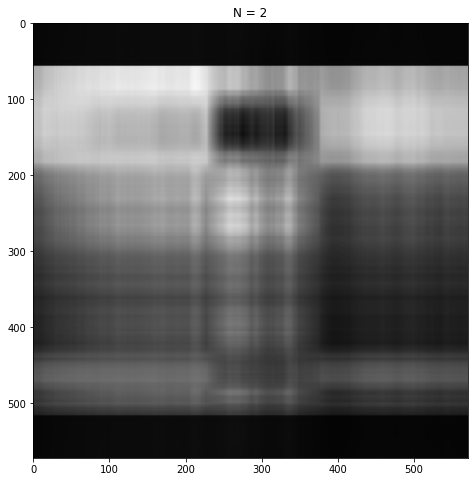

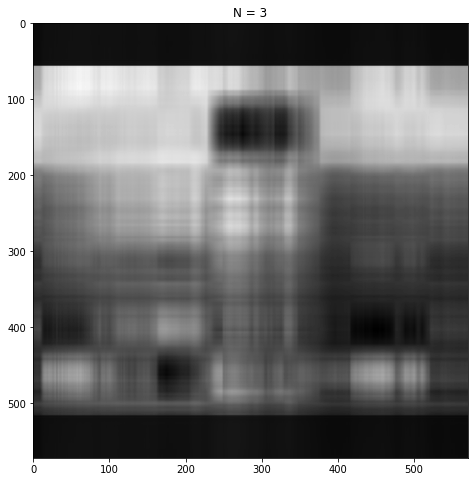

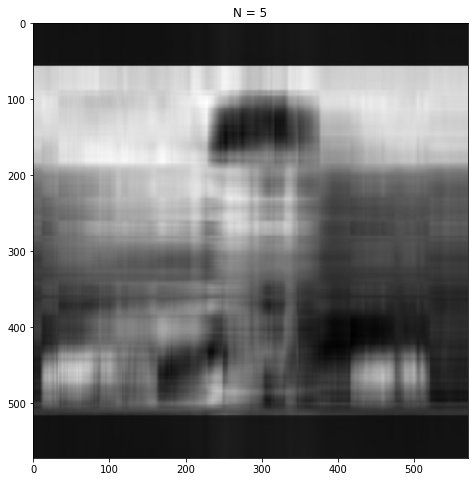

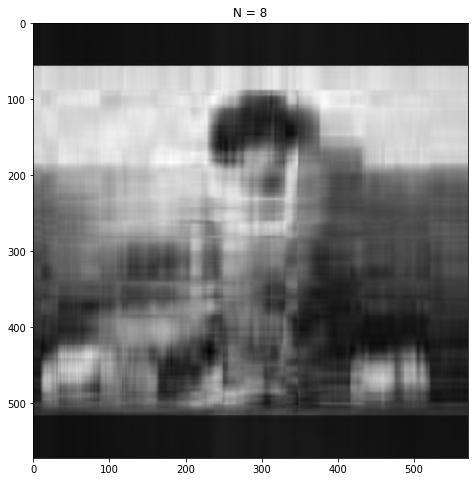

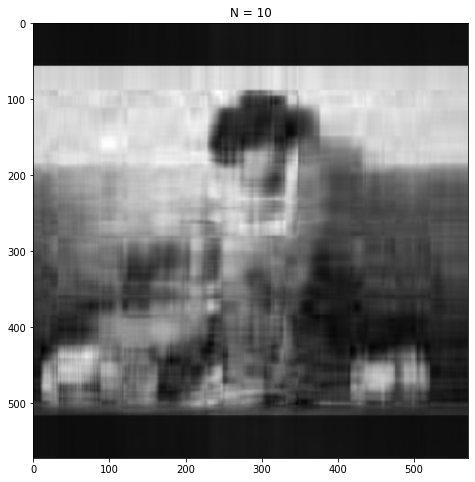

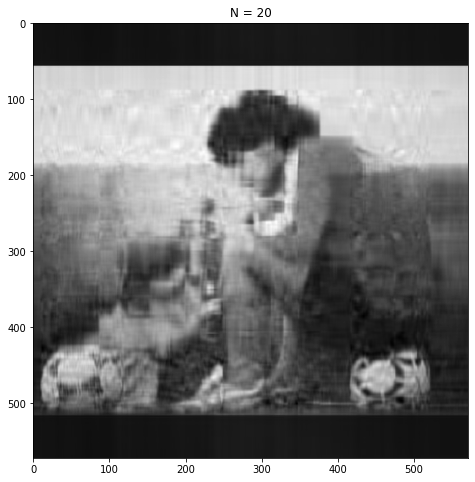

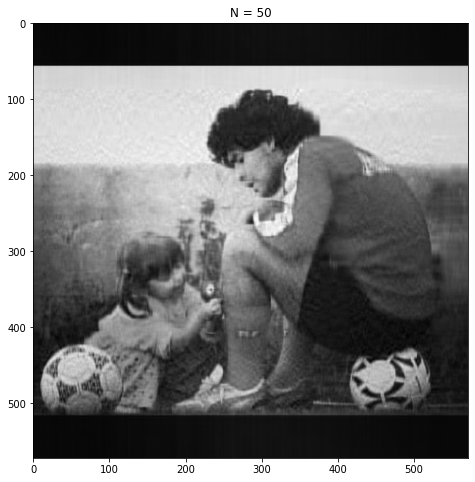

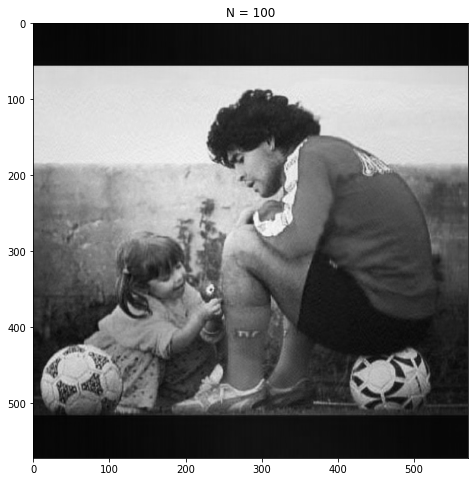

In [ ]:
for i in [2, 3, 5, 8, 10, 20, 50, 100]:
    reconstimg = np.matrix(U[:, :i]) * np.diag(D[:i]) * np.matrix(V[:i, :])
    plt.figure(figsize=(8,8))
    plt.imshow(reconstimg, cmap='gray')
    title = "N = %s" % i
    plt.title(title)
    plt.show()